# Import Libraries

In [56]:
import pandas as pd
import numpy as np

#Use Keras Neural Network Components. This will be used to construct the LSTM
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import LayerNormalization
from keras.layers import MultiHeadAttention
from keras.regularizers import L1L2
from keras.layers import Layer
from keras import Model
from keras.optimizers import Adam


#Import Tensorflow 
import tensorflow as tf

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion Matrix Library
from sklearn.metrics import confusion_matrix

# Ensure Reproducability of Results

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

# Fetch and Set Up Data

In [58]:
#Numerically Encode the Activities
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [59]:
DATDIR = "data/UCI HAR Dataset"
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "gravity_acc_x",
    "gravity_acc_y",
    "gravity_acc_z"
    ]

In [60]:
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_raw_signal_data(train_test, signal):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/Inertial Signals/{signal}_{'train' if train_test == 0 else 'test'}.txt"
    return pd.read_csv(file_path, delim_whitespace = True, header = None)

#Same purpose as previous function but, in this case, we are fetching ALL the raw signal data!
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_all_raw_signals(train_test):
    data_raw_signals = []
    for signal in SIGNALS:
        raw_signal_data = fetch_raw_signal_data(train_test, signal).to_numpy()
        data_raw_signals.append(raw_signal_data)
    
    data_raw_signals = np.array(data_raw_signals)
    return np.transpose(data_raw_signals, axes = (1, 2, 0))

#Fetch Labels
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_labels(train_test):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/y_{'train' if train_test == 0 else 'test'}.txt"
    return pd.get_dummies(pd.read_csv(file_path, delim_whitespace=True, header = None)[0]).to_numpy()

In [61]:
X_train, X_test, Y_train, Y_test = fetch_all_raw_signals(0), fetch_all_raw_signals(1), fetch_labels(0), fetch_labels(1)

N = X_train.shape[0]
T = X_train.shape[1]
D = X_train.shape[2]

print(N, T, D)

n_classes = Y_train.shape[1]
print(n_classes)
print(X_train.shape, Y_train.shape)

7352 128 9
6
(7352, 128, 9) (7352, 6)


# Define LSTM Architecture

## Architecture 1: 2 LSTM Layers With Attention Layer

In [62]:
##Hyperparameters
epochs = 30
batch_size = 128

n_hidden_1 = 64
n_hidden_2 = 32
n_hidden_3 = 16
n_hidden_4 = 8

dropout_p = 0.5
num_heads = 6

In [63]:
class AttentionBlock(Layer):
    def __init__(self, num_heads, key_dim, fc_dim):
        super().__init__()
        self.dropout = Dropout(0.1)
        self.attention = MultiHeadAttention(num_heads = num_heads, key_dim = key_dim, value_dim = key_dim)
        self.fc = Sequential([Dense(fc_dim, activation="relu")])
        
    def call(self, inputs, training):
        attention_output = self.attention(inputs, inputs)
        attention_output = self.dropout(attention_output, training = training)        
        fc_output = self.fc(attention_output)
        fc_output = self.dropout(fc_output, training = training)
        return fc_output


In [64]:
model = Sequential() #Initializing our Model Architecture

model.add(LSTM(n_hidden_1, input_shape = (T, D), return_sequences=True)) # Add an LSTM Layer
model.add(AttentionBlock(num_heads = num_heads, key_dim = n_hidden_1, fc_dim = n_hidden_2)) #Add a Multihead Attention Layer
model.add(BatchNormalization()) #Add Batch Normalization Layer

model.add(LSTM(n_hidden_3)) #Add another LSTM to come after the AttentionBlock
model.add(BatchNormalization()) #Add Batch Normalization Layer

model.add(Dense(n_hidden_4, activation = "relu")) #Add another Dense Layer
model.add(Dropout(dropout_p)) # Adding a dropout layer
model.add(Dense(n_classes, activation = 'softmax')) #Adding a Dense Layer with the Softmax Activation Function

model.summary() #Display a Summary of our model architecture

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128, 64)           18944     
                                                                 
 attention_block_3 (Attenti  (None, 128, 32)           101600    
 onBlock)                                                        
                                                                 
 batch_normalization_10 (Ba  (None, 128, 32)           128       
 tchNormalization)                                               
                                                                 
 lstm_11 (LSTM)              (None, 16)                3136      
                                                                 
 batch_normalization_11 (Ba  (None, 16)                64        
 tchNormalization)                                               
                                                      

In [65]:
# Compiling the model
optimizer = Adam(learning_rate=1e-4, weight_decay=1e-4, epsilon = 1e-10)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
58/58 [==============================] - 49s 759ms/step - loss: 1.6483 - accuracy: 0.3229 - val_loss: 1.7898 - val_accuracy: 0.2148
Epoch 2/30
58/58 [==============================] - 39s 683ms/step - loss: 1.4860 - accuracy: 0.3874 - val_loss: 1.7836 - val_accuracy: 0.3200
Epoch 3/30
58/58 [==============================] - 40s 686ms/step - loss: 1.3840 - accuracy: 0.4310 - val_loss: 1.7748 - val_accuracy: 0.2599
Epoch 4/30
58/58 [==============================] - 40s 691ms/step - loss: 1.3230 - accuracy: 0.4501 - val_loss: 1.7510 - val_accuracy: 0.4859
Epoch 5/30
58/58 [==============================] - 45s 779ms/step - loss: 1.2613 - accuracy: 0.4799 - val_loss: 1.7020 - val_accuracy: 0.5294
Epoch 6/30
58/58 [==============================] - 46s 789ms/step - loss: 1.2190 - accuracy: 0.4835 - val_loss: 1.6358 - val_accuracy: 0.5409
Epoch 7/30
58/58 [==============================] - 40s 689ms/step - loss: 1.1807 - accuracy: 0.5050 - val_loss: 1.5153 - val_accuracy: 0.6006

In [67]:
#Generate Confusion Matrix
Y_test_labels = np.argmax(Y_test, axis=1)
Y_prediction_labels = np.argmax(model.predict(X_test), axis = 1)
normalized_cm = confusion_matrix(Y_test_labels,Y_prediction_labels, normalize = 'true')

93/93 [==============================] - 25s 207ms/step


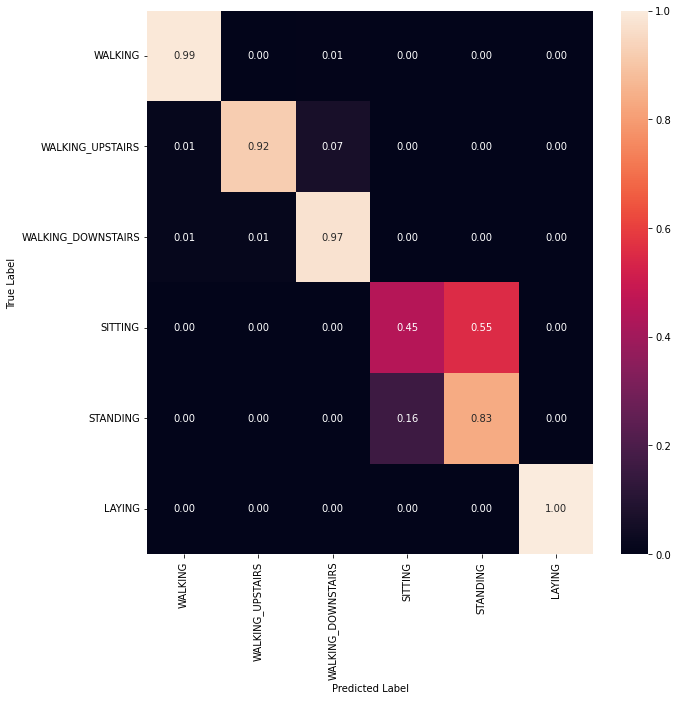

In [68]:
#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [69]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 7s 76ms/step - loss: 0.4220 - accuracy: 0.8595

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.42196816205978394, 0.8595181703567505]


## Architecture 2: Use 2 LSTM Layers

In [70]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 64
dropout_p = 0.5
n_hidden_2 = 32
n_hidden_3 = 16

In [71]:
model = Sequential() #Initializing our Model Architecture

#Define LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_1, input_shape=(T, D), return_sequences=True))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define the second LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_2))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define Dense Layer
model.add(Dense(n_hidden_3, activation = 'relu'))

#Define Dense Layer
model.add(Dense(n_classes, activation = 'softmax'))

#Print Model Summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128, 64)           18944     
                                                                 
 batch_normalization_12 (Ba  (None, 128, 64)           256       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 128, 64)           0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 batch_normalization_13 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 32)              

In [72]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [73]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 33s 62ms/step - loss: 0.9748 - accuracy: 0.5668 - val_loss: 0.6421 - val_accuracy: 0.6675
Epoch 2/30
460/460 [==============================] - 25s 54ms/step - loss: 0.6183 - accuracy: 0.6949 - val_loss: 5.3179 - val_accuracy: 0.3376
Epoch 3/30
460/460 [==============================] - 24s 52ms/step - loss: 0.4687 - accuracy: 0.7705 - val_loss: 0.3959 - val_accuracy: 0.8110
Epoch 4/30
460/460 [==============================] - 23s 51ms/step - loss: 0.3999 - accuracy: 0.8056 - val_loss: 2.1464 - val_accuracy: 0.6301
Epoch 5/30
460/460 [==============================] - 29s 63ms/step - loss: 0.3688 - accuracy: 0.8217 - val_loss: 0.3412 - val_accuracy: 0.8463
Epoch 6/30
460/460 [==============================] - 24s 53ms/step - loss: 0.3181 - accuracy: 0.8309 - val_loss: 0.4261 - val_accuracy: 0.8154
Epoch 7/30
460/460 [==============================] - 24s 52ms/step - loss: 0.3078 - accuracy: 0.8385 - val_loss: 0.4597 - val_accuracy:

In [74]:
#Generate Confusion Matrix
Y_test_labels = np.argmax(Y_test, axis=1)
Y_prediction_labels = np.argmax(model.predict(X_test), axis = 1)
normalized_cm = confusion_matrix(Y_test_labels,Y_prediction_labels, normalize = 'true')

93/93 [==============================] - 2s 16ms/step


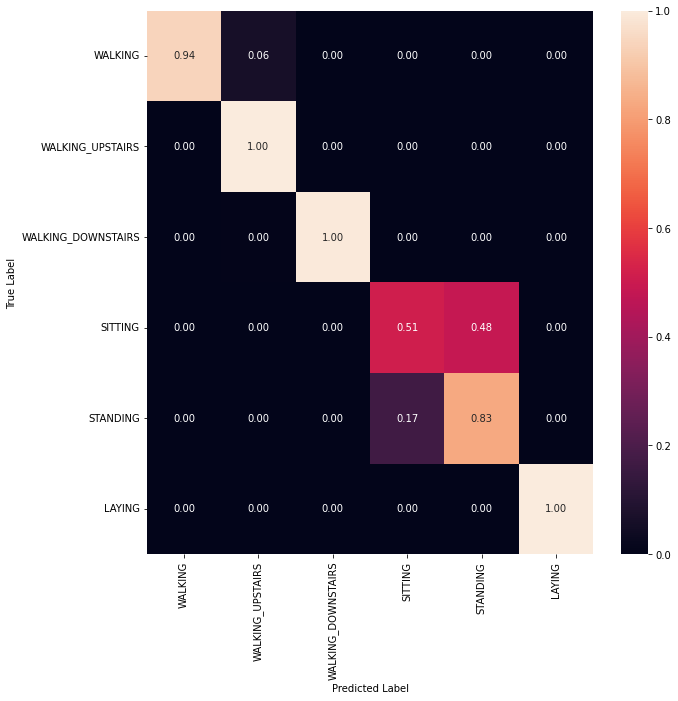

In [75]:
#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [76]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 2s 18ms/step - loss: 0.3739 - accuracy: 0.8772

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.37390294671058655, 0.8771632313728333]


## Architecture 3: Use 1 LSTM Layer

In [77]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 32
n_hidden_2 = 16
dropout_p = 0.5

In [78]:
model = Sequential() #Initializing our Model Architecture

# Add an LSTM Layer
model.add(LSTM(n_hidden_1, input_shape = (T, D)))

# Adding a dropout layer
model.add(Dropout(dropout_p))

#Add another Dense Layer
model.add(Dense(n_hidden_2, activation = "relu"))

# Adding a Dense Layer with the Softmax Activation Function
model.add(Dense(n_classes, activation = 'softmax'))

model.summary() #Display a Summary of our model architecture

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 32)                5376      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 6)                 102       
                                                                 
Total params: 6006 (23.46 KB)
Trainable params: 6006 (23.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [80]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 12s 22ms/step - loss: 1.3701 - accuracy: 0.3842 - val_loss: 1.1822 - val_accuracy: 0.4384
Epoch 2/30
460/460 [==============================] - 9s 20ms/step - loss: 1.1047 - accuracy: 0.4910 - val_loss: 0.8531 - val_accuracy: 0.5758
Epoch 3/30
460/460 [==============================] - 9s 20ms/step - loss: 0.7607 - accuracy: 0.6117 - val_loss: 0.6925 - val_accuracy: 0.6186
Epoch 4/30
460/460 [==============================] - 10s 21ms/step - loss: 0.6544 - accuracy: 0.6574 - val_loss: 0.8725 - val_accuracy: 0.6077
Epoch 5/30
460/460 [==============================] - 10s 21ms/step - loss: 0.5822 - accuracy: 0.7063 - val_loss: 0.5698 - val_accuracy: 0.7496
Epoch 6/30
460/460 [==============================] - 11s 25ms/step - loss: 0.5209 - accuracy: 0.7431 - val_loss: 0.5226 - val_accuracy: 0.7631
Epoch 7/30
460/460 [==============================] - 11s 25ms/step - loss: 0.4526 - accuracy: 0.7889 - val_loss: 0.6074 - val_accuracy: 0

In [81]:
#Generate Confusion Matrix
Y_test_labels = np.argmax(Y_test, axis=1)
Y_prediction_labels = np.argmax(model.predict(X_test), axis = 1)
normalized_cm = confusion_matrix(Y_test_labels,Y_prediction_labels, normalize = 'true')

93/93 [==============================] - 1s 8ms/step


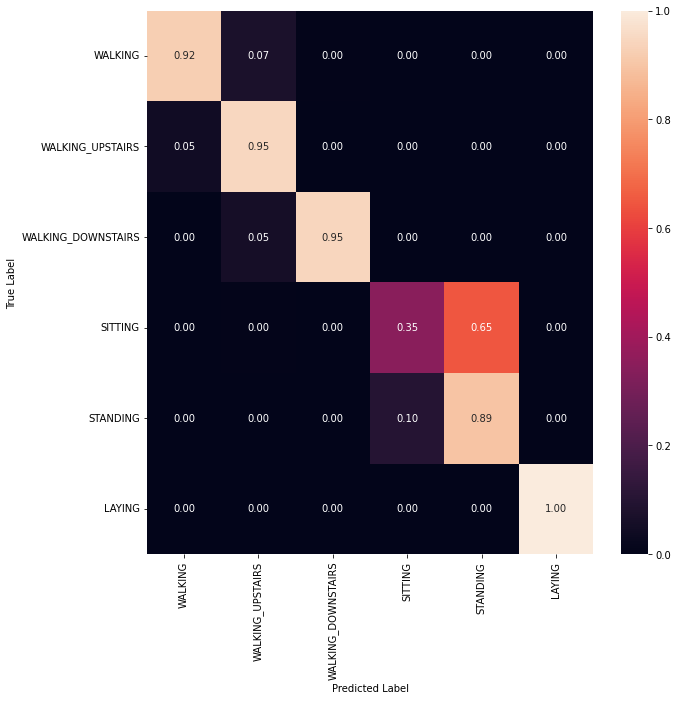

In [82]:
#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [83]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 8ms/step - loss: 0.4535 - accuracy: 0.8432

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.45351895689964294, 0.8432304263114929]
